# ADA 2019 – Project Milestone 2
## Evolution of the Music Industry
### Team *Master Yada*:
Jan Waligorski, Jean-Baptiste Membrado, Thomas Petit-Jean, Alexandre Cionca

**Datasets**
- Releases.xml (6.5GB zipped): each Row is a released song/album on a specific format, with specific specs. Because of its size (40Go), we did some processing on the ADA cluster and saved the smaller extracted DataFrame locally. To do some tests, we also extracted a smaller dataset (100Mo) named releases_small.xml.
- Masters.xml (197.7MB zipped): each Row is a Master, i.e. the support of various releases

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark

from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark import SparkContext

import discogs_client
import os

In [2]:
## Discogs API access for python
# Personnal Discogs API access token
my_token = 'ZgyCYriwcYpJcxCNPHdpDongjdVQkmvOaYzrhzzR'

d = discogs_client.Client('ExampleApplication/0.1', user_token = my_token)

In [3]:
# Setting up PySpark
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.7.0 pyspark-shell'

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '12g'),  # find
                                   ('spark.driver.memory','6g'), # your
                                   ('spark.driver.maxResultSize', '4G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

In [4]:
# Opening masters.xml as a Spark DataFrame
discogs_masters = spark.read.format("xml") \
                        .option("rowTag","master") \
                        .load("discogs_20191101_masters.xml.gz")

In [5]:
# Display schema
discogs_masters.printSchema()

root
 |-- _id: long (nullable = true)
 |-- artists: struct (nullable = true)
 |    |-- artist: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- anv: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- join: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- role: string (nullable = true)
 |    |    |    |-- tracks: string (nullable = true)
 |-- data_quality: string (nullable = true)
 |-- genres: struct (nullable = true)
 |    |-- genre: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- images: struct (nullable = true)
 |    |-- image: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- _VALUE: string (nullable = true)
 |    |    |    |-- _height: long (nullable = true)
 |    |    |    |-- _type: string (nullable = true)
 |    |    |    |-- _uri: string (nullable = true)
 |    |  

In [12]:
# Missing years
discogs_masters.filter(discogs_masters.year == 0).show()

+-------+--------------------+------------+--------------------+--------------------+------------+-----+--------------------+--------------------+--------------------+----+
|    _id|             artists|data_quality|              genres|              images|main_release|notes|              styles|               title|              videos|year|
+-------+--------------------+------------+--------------------+--------------------+------------+-----+--------------------+--------------------+--------------------+----+
|1361032|[[[Justin E. Bell...|     Correct|  [[Stage & Screen]]|[[[, 600, seconda...|    11978877| null|                null|Tyranny Official ...|                null|   0|
|  31787|[[[, 134, , Chris...|     Correct|      [[Electronic]]|[[[, 450, primary...|       43467| null|      [[Deep House]]|            Do Right|[[[362, true, htt...|   0|
| 175705|[[[, 10352, &, Pr...|     Correct|          [[Reggae]]|[[[, 600, primary...|     1536933| null|          [[Reggae]]|83 Struggl

In [6]:
discogs_masters.filter(discogs_masters.year == 0).count()

97800

In [7]:
# Number of masters
discogs_masters.count()

1587241

> As seen on the printed scheme above, the data require some filtering of the desired features as well as some data entries.

In [15]:
## The following dataframes were generated on the full dataset thanks to the cluster
## DO NOT RUN this cell: it is just to show how the various files were obtained

r2 = spark.read.format("xml") \
    .option("rowTag","release") \
    .load("releases_small.xml")

## years.csv
# Number of release per year
release_count = r2.select(F.year(F.to_date(r2.released)).alias('year')) \
             .groupBy('year').agg(count("*").alias('numb_rel')).fillna(0)

## genres.csv
# Number of release per year and per genre
df_genres = r2.select(explode(r2.genres.genre).alias("genre"), \
                      F.year(F.to_date(r2.released)).alias('year')) \
              .groupBy('year','genre') \
              .agg(count("*").alias('numb_rel'))

## styles.csv
# Number of electronic release per year and per style (a style being a 'subgenre')
df_styles = r2.select(F.year(F.to_date(r2.released)).alias('year'), \
                     F.explode(r2.genres.genre).alias("genre"), \
                     'styles').filter(F.col('genre') == 'Electronic') \
                         .select('year',F.explode(r2.styles.style).alias('style')) \
                         .groupBy('year','style') \
                         .agg(count("*").alias('numb_rel')).fillna(0, subset = ['year'])

## master_release_format.json
# For each master : (number of / labels / format / year) of the corresponding releases 
dfMR = r2.na.drop(subset=["_id","master_id._VALUE","master_id._is_main_release","labels"])\
         .select(r2._id.alias('id'), \
                r2.master_id._VALUE.alias('master_id'), \
                r2.master_id._is_main_release.alias('is_main'), \
                r2.labels.label._name[0].alias('label'), \
                r2.formats.format._name[0].alias('format'), \
                F.year(F.to_date(r2.released)).alias('year')) \
         .groupBy("master_id").agg(collect_set("label").alias('labels'),
                                   count('id'),
                                   collect_set("format"),
                                   collect_list("year"))

NameError: name 'count' is not defined

## Data Pre-Processing

In [8]:
# Reducing the number of features since some of them seems pretty useless
# and to improve computation time as well.
selected_features = ['_id', 'artists', 'data_quality', 'genres', 'styles', 'title', 'year']

# A first filtering could be to use the "data_quality" feature. It describe if the entry has
# been "validated" by the Discogs administrators. Thus, we will only keep "Correct" entries.

# A second preprocessing step would be to remove all entries with missing years. Since our
# dataset is big enough, it is easier for us (and for later computations) to remove these rows
# instead of filling the missing values. Note that Masters with no publication years 

masters = discogs_masters.select(selected_features)\
                            .filter(discogs_masters.data_quality == "Correct")\
                            .filter(discogs_masters.year > 0)\
                            .dropna(subset = "year")

In [9]:
# Number of total elements after filtering
masters.count()

1485370

In [10]:
# Storing Master into Pandas
master_DF = masters.toPandas().rename(columns = {'_id':'master_id'})

master_DF.head()

,master_id,artists,data_quality,genres,styles,title,year
0,18500,"([(Samuel L, 212070, , Samuel L Session, , )],)",Correct,"([Electronic],)","([Techno],)",New Soil,2001
1,18512,"([(, 212070, , Samuel L Session, , )],)",Correct,"([Electronic],)","([Tribal, Techno],)",Psyche EP,2002
2,27800,"([(, 278, , Peshay, , )],)",Correct,"([Electronic],)","([Drum n Bass],)",Renegades Of Funk,2001
3,57416,"([(, 3225, , Vince Watson, , )],)",Correct,"([Electronic],)","([Techno],)",Tuff Trax #1 - Basic Functions,1996
4,57427,"([(, 3225, , Vince Watson, , )],)",Correct,"([Electronic],)","([Techno, Downtempo],)",The eMotion Sequence,2006


In [11]:
# Loading of music Label and Format (cd or vinyl) list for each master_id
# (previously computed on the cluster)
labels = pd.read_json('master_labels_format.json', lines = True)\
            .rename(columns = {'count(id)':'n_releases',
                               'collect_set(format)':'format'})\
            .set_index('master_id')

labels.head()

,labels,n_releases,format
master_id,,,
474,[Stateart],3,[Vinyl]
964,[Stuffrecords],2,[Vinyl]
1677,[Maurizio],10,"[File, Vinyl]"
1697,[Cronomi Records],3,[File]
1806,[E:Motion],2,[CD]


In [12]:
# Joining datasets together
master_full_DF = master_DF.join(labels, on = 'master_id', how = 'inner')\
                            .drop(columns = ['data_quality'])
master_full_DF.head()

,master_id,artists,genres,styles,title,year,labels,n_releases,format
0,18500,"([(Samuel L, 212070, , Samuel L Session, , )],)","([Electronic],)","([Techno],)",New Soil,2001,[SLS],3,"[CD, Vinyl]"
1,18512,"([(, 212070, , Samuel L Session, , )],)","([Electronic],)","([Tribal, Techno],)",Psyche EP,2002,[SLS],2,[Vinyl]
2,27800,"([(, 278, , Peshay, , )],)","([Electronic],)","([Drum n Bass],)",Renegades Of Funk,2001,[Renegade Recordings],2,[CD]
3,57416,"([(, 3225, , Vince Watson, , )],)","([Electronic],)","([Techno],)",Tuff Trax #1 - Basic Functions,1996,[Club Craft],2,[Vinyl]
4,57427,"([(, 3225, , Vince Watson, , )],)","([Electronic],)","([Techno, Downtempo],)",The eMotion Sequence,2006,[Delsin],2,"[CD, Vinyl]"


In [13]:
# Extracting Genres & Styles out of the RDD rows into lists of strings
master_full_DF.loc[:, 'genres'] = master_full_DF.genres.apply(lambda x: x.genre)

# Some master have "None" Style and thus, we must define a alternate function.
def get_style(row):
    if row is not None:
        return row.style
    else:
        return ['unknown']

master_full_DF.loc[:, 'styles'] = master_full_DF.styles.apply(get_style)

master_full_DF.head()

,master_id,artists,genres,styles,title,year,labels,n_releases,format
0,18500,"([(Samuel L, 212070, , Samuel L Session, , )],)",[Electronic],[Techno],New Soil,2001,[SLS],3,"[CD, Vinyl]"
1,18512,"([(, 212070, , Samuel L Session, , )],)",[Electronic],"[Tribal, Techno]",Psyche EP,2002,[SLS],2,[Vinyl]
2,27800,"([(, 278, , Peshay, , )],)",[Electronic],[Drum n Bass],Renegades Of Funk,2001,[Renegade Recordings],2,[CD]
3,57416,"([(, 3225, , Vince Watson, , )],)",[Electronic],[Techno],Tuff Trax #1 - Basic Functions,1996,[Club Craft],2,[Vinyl]
4,57427,"([(, 3225, , Vince Watson, , )],)",[Electronic],"[Techno, Downtempo]",The eMotion Sequence,2006,[Delsin],2,"[CD, Vinyl]"


## Master or Release
Albums on discogs are ordered as Master (unique) and Releases (different version of a Master).

In [14]:
# Counting the number of Master and Releases per year
master_rel_per_year = master_full_DF[['year', 'n_releases']].groupby('year')\
                                                            .agg({'n_releases':['sum','mean','std'],
                                                                  'year':'count'})\
                                                            .rename(columns = {'sum':'n_rel', 'mean':'mean_rel',
                                                                               'std':'std_rel', 'count':'n_mast'})
master_rel_per_year

n_releases                       year
            sum      mean       std  count
year                                      
1860          2  2.000000       NaN      1
1896          5  2.500000  0.707107      2
1898          4  2.000000  0.000000      2
1899          3  3.000000       NaN      1
1902          7  2.333333  0.577350      3
...         ...       ...       ...    ...
2015     101262  3.011062  2.306587  33630
2016     101527  2.985298  2.092589  34009
2017      92460  2.911667  1.961807  31755
2018      70401  2.835206  2.339178  24831
2019        308  2.750000  1.857539    112

[122 rows x 4 columns]

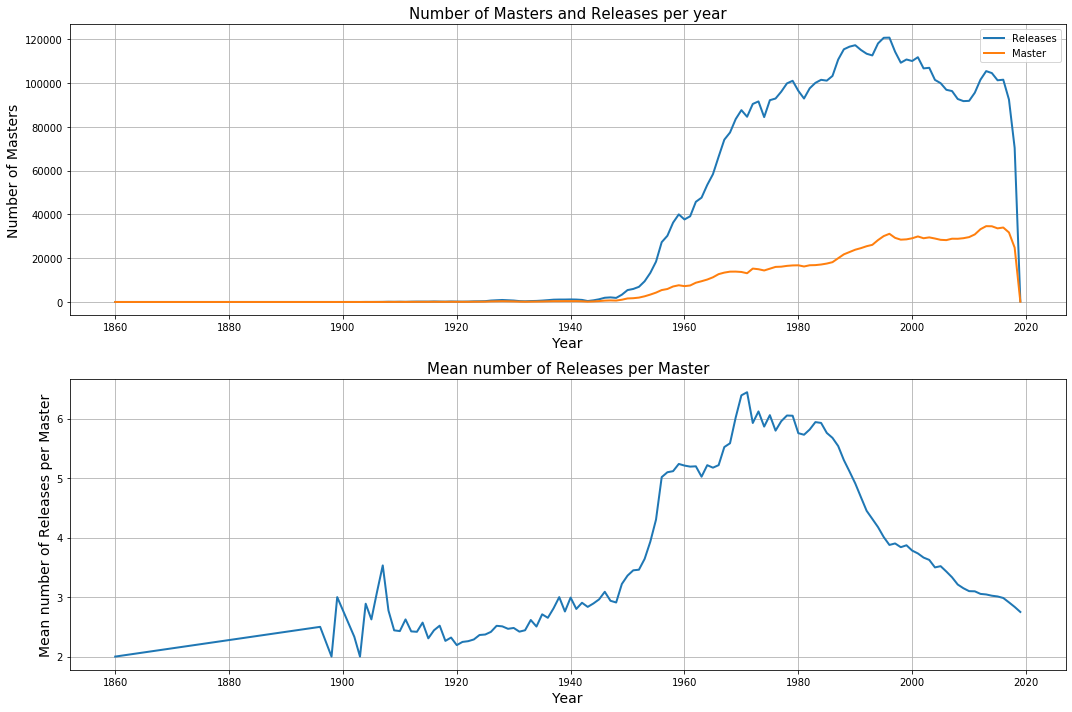

In [15]:
fig, ax = plt.subplots(figsize = (15, 10))

plt.subplot(2,1,1)
plt.title('Number of Masters and Releases per year', fontsize = 15)

plt.plot(master_rel_per_year.n_releases['sum'], linewidth = 2)
plt.plot(master_rel_per_year.year, linewidth = 2)

plt.xlabel('Year', fontsize = 14)
plt.ylabel('Number of Masters', fontsize = 14)

plt.grid()

plt.legend(['Releases', 'Master'])

plt.subplot(2,1,2)
plt.title('Mean number of Releases per Master', fontsize = 15)

plt.plot(master_rel_per_year.n_releases['mean'], linewidth = 2)

plt.xlabel('Year', fontsize = 14)
plt.ylabel('Mean number of Releases per Master', fontsize = 14)

plt.grid()
plt.tight_layout()

In [40]:
import plotly.graph_objects as go

x = master_rel_per_year.index.values
fig = go.Figure()

for g, label in zip([master_rel_per_year.n_releases['sum'], master_rel_per_year.year['count']],
                    ['releases', 'masters']):
    
    fig.add_trace(go.Scatter(
        x=g.index.values,
        y=g.values,
        mode='lines',
        name=g.name,
    ))
    
fig.update_layout(
    title="Discogs Number of Releases & Masters per year",
    height = 600,
    xaxis_title="Year",
    yaxis_title="Count",
    showlegend=True,
    xaxis=go.layout.XAxis(
        rangeslider=dict(
            visible=True
        ),
        type="linear",
        range=[1940, 2019]
    ),
)

fig.show()

> Number of Releases may be inaccurate in this plot. Indeed, if a release (re-edition for example) is out 5 years after the master year, it will still count for the **master year** (and not the actual release year). This will be improved by using the *Release* dataset.

On this graph, we can see the evolutions of the number of masters - thus albums - per year. Nota bene, we correlate the number of releases with the health of the music industry; as if it grows and generate money, it will reinvest that money into the making and marketing of new releases.

From the 50s, the post-World War II economic expansion had a huge impact on consumerism, especially in the U.S. Goods and services were created deliberately for young people as spending power skyrocketted. The access of music through the democratisation of vinyl created a huge expansion of the newborn music industry. We can hypothesize that the dip in the 70s comes respectively from the oil crash in 1973 and the energy crisis in 1979. These events led to a period of recession, affecting all the markets, including the music one. One could argue that the second dip in the 2000s was caused by the internet as music piracy exploded (the famous peer-to-peer website Nasper was launched in 1999) leading to a decline in CD sales, thus again affecting the industry. Surely, the financial crash of 2008 did not help. The huge peak in the recent years could be the development of many streaming platforms - as increasing internet data rates allowed continous streaming of media - democratizing even more various artists.

Notwithstanding this last point, we can distinguish a certain form of exhausation (i.e. if we compare this market with the demographic expansion) maybe caused by a saturation of various artists led by the streaming revolution.

## Genres & Styles

In [95]:
## Genres per year
exploded_genres = master_full_DF[['year', 'genres', 'labels',
                                  'format', 'n_releases']].explode('genres')

genres_DF = exploded_genres.groupby(['year', 'genres']).size().unstack().fillna(0)
genres_DF.head()

genres,Blues,Brass & Military,Children's,Classical,Electronic,"Folk, World, & Country",Funk / Soul,Hip Hop,Jazz,Latin,Non-Music,Pop,Reggae,Rock,Stage & Screen
year,,,,,,,,,,,,,,,
1860,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1902,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


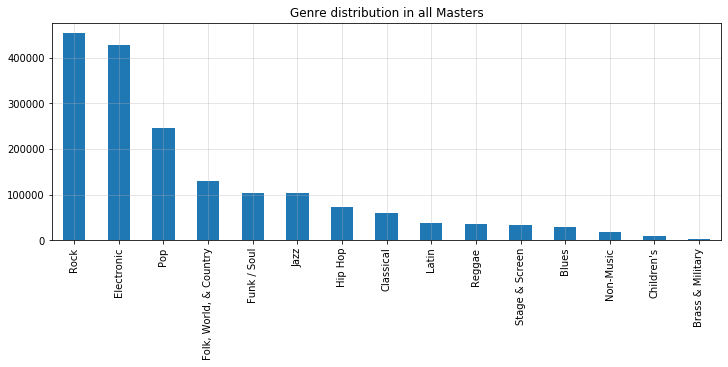

In [108]:
fig, ax = plt.subplots(figsize = (12, 4))

plt.title('Genre distribution in all Masters')

exploded_genres.genres.value_counts().plot.bar()

plt.grid(alpha = .4)

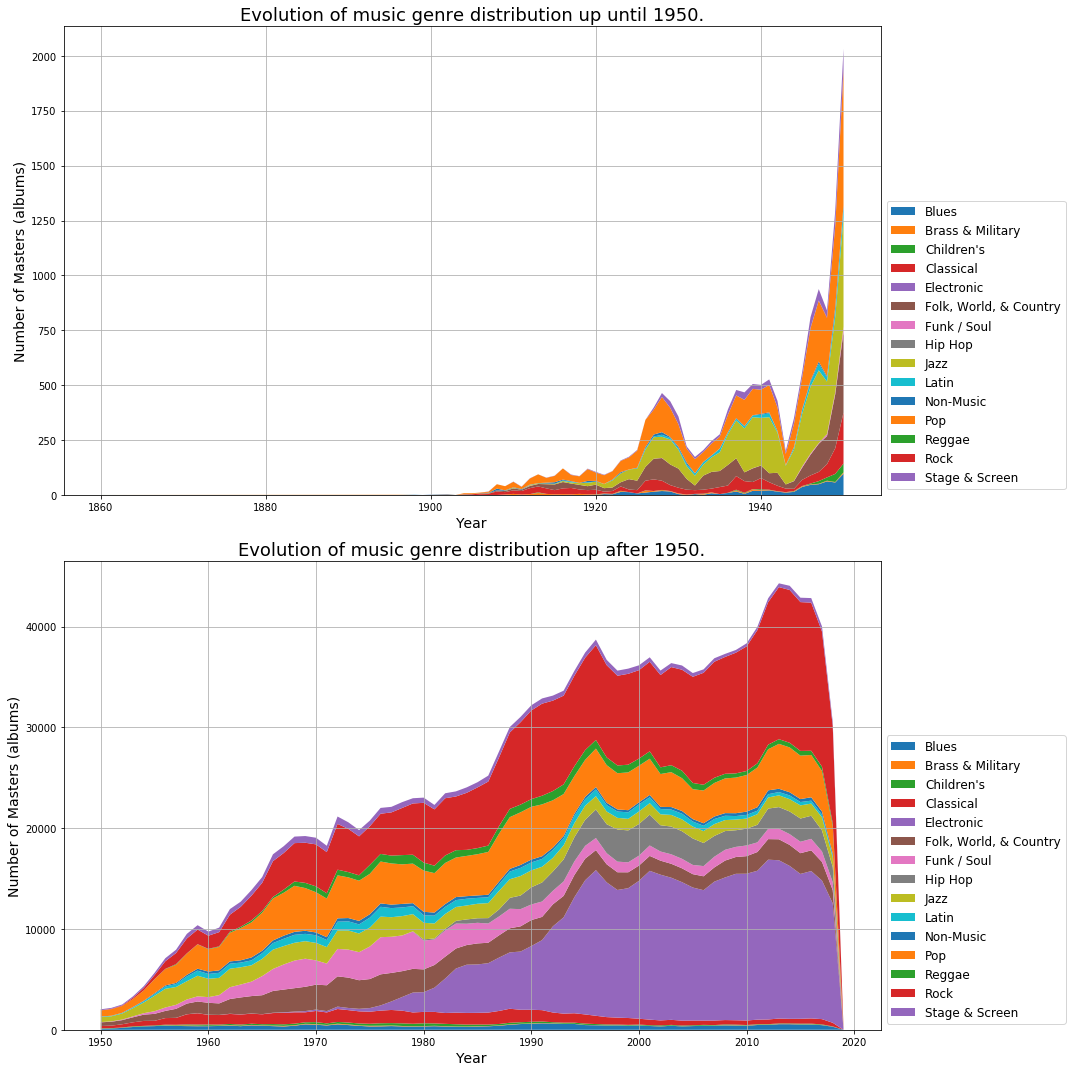

In [18]:
fig, ax = plt.subplots(figsize = (15, 15))

# Choice to normalize by the total number of master per year and to seperate into 2 plots
normalize, sep_year = False, 1950

for idx, data in enumerate([genres_DF.loc[:sep_year], genres_DF.loc[sep_year:]]):
    
    plt.subplot(2,1,1 +idx)
    
    if normalize:
        to_plot = data.values.T / data.values.sum(axis = 1)
    else:
        to_plot = data.values.T
    
    if idx == 0:
        plt.title('Evolution of music genre distribution up until {:d}.'
                  .format(sep_year), fontsize = 18)
    else:
        plt.title('Evolution of music genre distribution up after {:d}.'
                  .format(sep_year), fontsize = 18)
     
    plt.stackplot(data.index.values, to_plot,
                  labels = data.columns.values)
    
    plt.xlabel('Year', fontsize = 14)
    plt.ylabel('Number of Masters (albums)', fontsize = 14)
    
    plt.grid()
    plt.legend(loc = 'lower left', ncol = 1, fontsize = 12, bbox_to_anchor=(1, 0))
    
plt.tight_layout()

In [166]:
import plotly.graph_objects as go

x = genres_DF.index.values
fig = go.Figure()

for idx, g in genres_DF.transpose().iterrows():
    if idx == 'Blues':
        normalized = 'percent'
    else:
        normalized = None
    
    fig.add_trace(go.Scatter(
        x=g.index.values,
        y=g.values,
        mode='lines',
        name=g.name,
        stackgroup='one',
        hovertemplate='Year: %{x}<br> Percentage: %{y:2.2f}%',
        groupnorm=normalized # sets the normalization for the sum of the stackgroup
    ))
    
fig.update_layout(
    title="Discogs Genre Distribution over the Years",
    height = 600,
    xaxis_title="Year",
    yaxis_title="Percentage of Master",
    showlegend=True,
    xaxis=go.layout.XAxis(
        rangeslider=dict(
            visible=True
        ),
        type="linear",
        range=[1940, 2019]
    ),
    yaxis=dict(
        type='linear',
        range=[1, 105],
        ticksuffix='%'))

fig.show()

Here we can see the evolution of genres throughout the years. Some genres appeared and exploded like Electronic music in the 80s caused by the creation of samplers and drum machines. Some nearly dissapeared like blues.

From this graph, we can see that recently the most dominant genres are Rock and Electronic but this doesn't correspond to the recent charts for Rock. Hiphop is in fact more relevant nowadays than rock in terms of streams/sales. We could argue that as the audience of Hiphop artists mainly consume this type of music on streaming platforms like Apple music, Spotify, Youtube, etc..., they make, on one hand less albums and more singles, and on the other hand simply do not release their music physically and only digitally, following the trends.

As Discogs is a library mostly composed of physical releases (CD, Vinyl, casette, ...), naturally the genres that release the most physically are over-represented on our graph.

In [53]:
genrestyles = master_full_DF.loc[:,['year', 'genres', 'styles']]
genrestyles['period'] = ''

for periods in [0, 1950, 1975, 2000]:
    genrestyles.loc[genrestyles.year >= periods, 'period'] = periods
gs_explode = genrestyles.explode('genres')
gs_explode.head()

,year,genres,styles,period
0,2001,Electronic,[Techno],2000
1,2002,Electronic,"[Tribal, Techno]",2000
2,2001,Electronic,[Drum n Bass],2000
3,1996,Electronic,[Techno],1975
4,2006,Electronic,"[Techno, Downtempo]",2000


In [196]:
def top_values(x, n = 10):
    return x.value_counts().head(n)

In [204]:
gs_periods = gs_explode.explode('styles').groupby(['genres']).styles
gs_periods = gs_periods.apply(top_values).reset_index()
gs_periods = gs_periods.loc[gs_periods.level_1 != '']

In [205]:
gs_ids = gs_periods.groupby('genres').styles.sum().index.tolist()
gs_labels = gs_ids.copy()
gs_values = gs_periods.groupby('genres').styles.sum().tolist()
gs_parents = ['' for _ in gs_values]

for idx, row in gs_periods.iterrows():
    gs_parents.append(row.genres)
    gs_ids.append(row.genres+'-'+row.level_1)
    gs_labels.append(row.level_1)
    gs_values.append(row.styles)

In [206]:
fig = go.Figure(go.Sunburst(
    ids=gs_ids,
    labels=gs_labels,
    parents=gs_parents,
    values=gs_values,
    branchvalues="total",
))
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

fig.show()

### Labels

In [20]:
# Storing the number of unique label per year
label_per_year = exploded_genres.groupby('year').agg({'labels':'nunique'})

# Storing the number of unique label per genre
label_per_genre = exploded_genres.groupby('genres').agg({'labels':'nunique', 
                                                        'n_releases':'sum'})\
                                    .sort_values(by = 'labels', ascending = False)

label_per_genre

,labels,n_releases
genres,,
Rock,219404,2347073
Electronic,162519,1616961
Pop,87323,1071904
"Folk, World, & Country",50471,443900
Funk / Soul,45485,538592
Jazz,43661,493667
Hip Hop,33854,303504
Classical,20562,240402
Latin,18604,148560


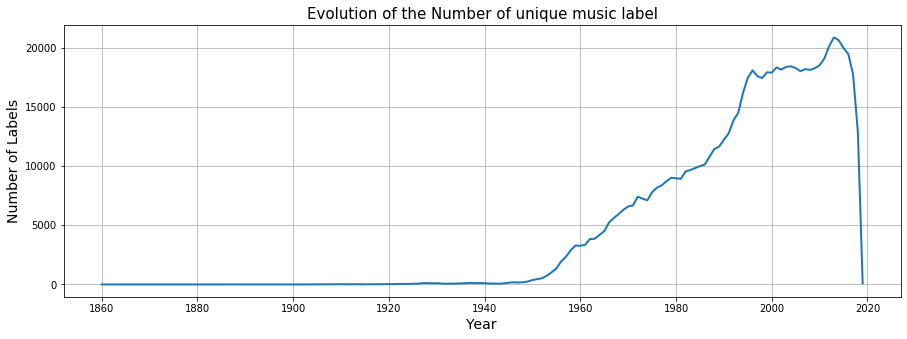

In [21]:
fig, ax = plt.subplots(figsize = (15, 5))
plt.title('Evolution of the Number of unique music label',
          fontsize = 15)

plt.plot(label_per_year.index.values, label_per_year.values, linewidth = 2)

plt.xlabel('Year', fontsize = 14)
plt.ylabel('Number of Labels', fontsize = 14)

plt.grid()

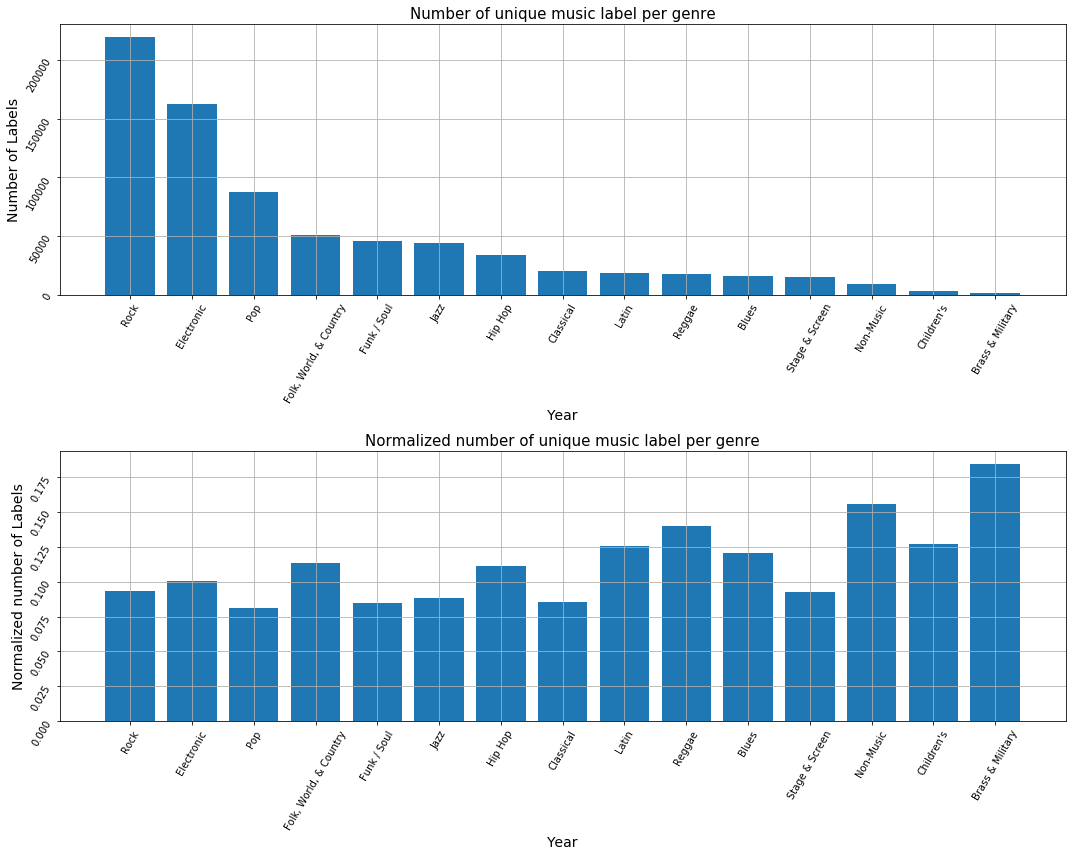

In [22]:
fig, ax = plt.subplots(figsize = (15, 12))

ax = plt.subplot(2,1,1)
plt.title('Number of unique music label per genre',
          fontsize = 15)

plt.bar(label_per_genre.index.values, label_per_genre.labels.values, linewidth = 2)

ax.tick_params(labelrotation = 60)

plt.xlabel('Year', fontsize = 14)
plt.ylabel('Number of Labels', fontsize = 14)

plt.grid()

ax = plt.subplot(2,1,2)
plt.title('Normalized number of unique music label per genre',
          fontsize = 15)

plt.bar(label_per_genre.index.values,
        label_per_genre.labels.values/label_per_genre.n_releases.values, linewidth = 2)

ax.tick_params(labelrotation = 60)

plt.xlabel('Year', fontsize = 14)
plt.ylabel('Normalized number of Labels', fontsize = 14)

plt.grid()
plt.tight_layout()

> Here, the bigger the barplot, the better the diversity of labels per genre. We can comment that :
- Pop, the genre with the most capitalization per artist, show less label diversity maybe because all the songs come out on big labels that are not numerous.
- Niche genres like Jazz, Funk/Soul show less label diversity as they have less consumers, thus less market shares so not many labels can successfully coexist and survive.

In [23]:
label_DF = exploded_genres.groupby(['year', 'genres'])\
                            .agg({'labels':'nunique'})\
                            .unstack().fillna(0)['labels']
label_DF.head()

genres,Blues,Brass & Military,Children's,Classical,Electronic,"Folk, World, & Country",Funk / Soul,Hip Hop,Jazz,Latin,Non-Music,Pop,Reggae,Rock,Stage & Screen
year,,,,,,,,,,,,,,,
1860,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1902,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


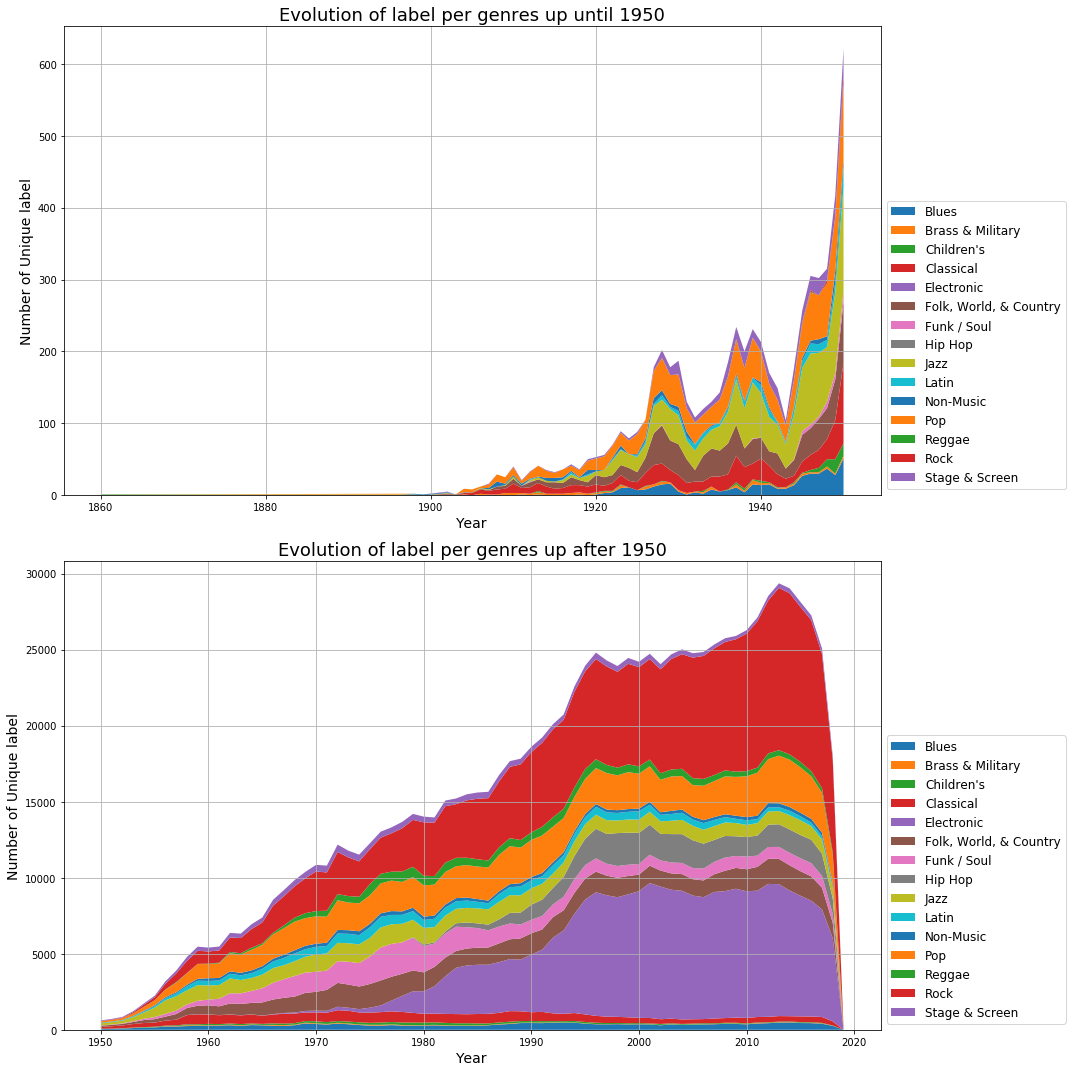

In [24]:
fig, ax = plt.subplots(figsize = (15, 15))

# Choice to normalize by the total number of master per year and to seperate into 2 plots
normalize, sep_year = False, 1950

for idx, data in enumerate([label_DF.loc[:sep_year], label_DF.loc[sep_year:]]):
    
    plt.subplot(2,1,1 +idx)
    
    if normalize:
        to_plot = data.values.T / data.values.sum(axis = 1)
    else:
        to_plot = data.values.T
    
    if idx == 0:
        plt.title('Evolution of label per genres up until {:d}'
                  .format(sep_year), fontsize = 18)
    else:
        plt.title('Evolution of label per genres up after {:d}'
                  .format(sep_year), fontsize = 18)
     
    plt.stackplot(data.index.values, to_plot,
                  labels = data.columns.values)
    
    plt.xlabel('Year', fontsize = 14)
    plt.ylabel('Number of Unique label', fontsize = 14)
    
    plt.grid()
    plt.legend(loc = 'lower left', ncol = 1, fontsize = 12, bbox_to_anchor=(1, 0))
    
plt.tight_layout()

The evolution of label per genre doesn't show any particularly stricking informations. Nevertheless, we can highlight that the number of label for all genres reached a plateau around 1995 and that *Rock* appears to be the only genre with an increasing number of labels during this period. This could be explained by a "return" of the Rock popularity following the rise of the Electronic (early 1990's).

## Music support
As new technologies redefined the way people consume music, we will have a look at the evolution of music support and formats.

In [25]:
# Storing number of releases per format per year
formats = master_full_DF[['year', 'genres', 'format']].explode('format')\
                                                        .groupby(['year', 'format'])\
                                                        .agg({'format':'count'})

In [26]:
# Creating an unstacked Formats dataframe
formats_DF = formats.unstack().fillna(0)['format']
formats_DF = formats_DF.loc[:, formats_DF.sum(axis = 0) > 5000]
formats_DF

format,8-Track Cartridge,CD,CDr,Cassette,DVD,File,Shellac,VHS,Vinyl
year,,,,,,,,,
1860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1896,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1899,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1902,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2015,6.0,14830.0,4831.0,4851.0,194.0,16985.0,0.0,5.0,17060.0
2016,13.0,14414.0,4521.0,5271.0,149.0,17425.0,0.0,20.0,17292.0
2017,11.0,13263.0,3873.0,4825.0,123.0,16075.0,0.0,19.0,17075.0


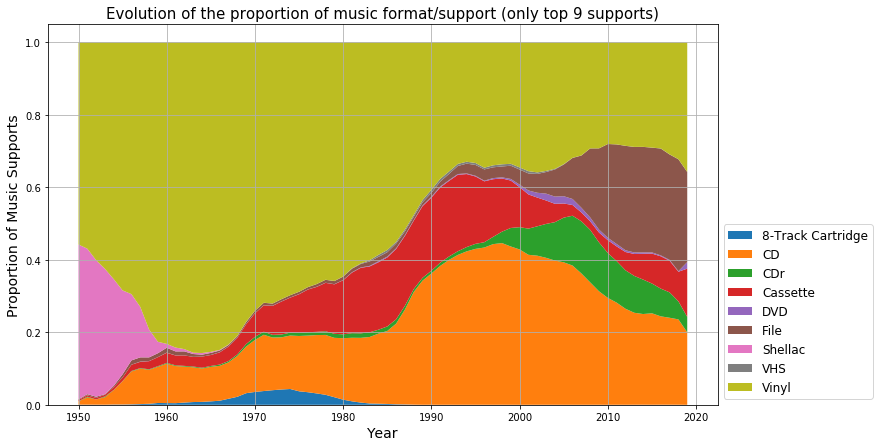

In [31]:
fig, ax = plt.subplots(figsize = (12, 7))
plt.title('Evolution of the proportion of music format/support (only top 9 supports)',
          fontsize = 15)

formats_1950_plus = formats_DF.loc[1950:]

plt.stackplot(formats_1950_plus.index.values,
              formats_1950_plus.values.T/formats_1950_plus.values.sum(axis = 1),
              labels = formats_1950_plus.columns)

plt.xlabel('Year', fontsize = 14)
plt.ylabel('Proportion of Music Supports', fontsize = 14)

plt.grid()
plt.legend(loc = 'lower left', ncol = 1, bbox_to_anchor=(1, 0), fontsize = 12)

On this graph, we can see on which format music is released. From the colossal dominance of Vinyl to the technological revolution leading to CD, the way we consume music is everchanging. Note that this graph does not only represent the format on which labels released their music on the actual year of the release, but it also includes all the reedition that were made a posteriori (CD was invented in 1982, but we see this format before on the graph). Thus, a Master from the 1960's that was re-edited and ported to CD's later in the 1985's will appear as a CD release from the 1960's (year of the Master).

Also, as streaming is the main way we consume music nowadays, "File" should be the main format but it is not the case here. From this and our other graphs, we suspect the File database is not complete on Discogs.

## Discogs Social Media :

In [392]:
def get_label(master_id):
    
    labels = []
    
    for rel in d.master(master_id).versions:
        for lab in rel.labels:
            labels.append(lab.name)
            
    return labels

get_lab = F.udf(lambda master_id: get_label(master_id))

get_label(12345)

['Impact Records (23)', 'Impact Records (23)', 'Impact Records (23)']

In [295]:
jsp = d.master(1234)

for ver in jsp.versions:
    print(ver.labels)

[<Label 461 'Neue Heimat'>]
[<Label 461 'Neue Heimat'>]
[<Label 461 'Neue Heimat'>]


In [109]:
fdp = masters.take(1)[0]
get_label(fdp._id)

['SLS', 'SLS', 'SLS']

Here we prove that the Discogs API is actually dangerous for our mental sanity.

In [13]:
# %load discogs_requests.py
import discogs_client
import numpy as np
import urllib
from urllib.request import urlopen
from bs4 import BeautifulSoup
import json
import pickle
import os


class DiscogsInstance(object):

    def __init__(self):
        self.consumer_key = 'xhTPysTNbOaratTZVDXs'
        self.consumer_secret = 'aluUBfaChtVFsGKqQqrzVBLZmktGwPGc'
        self.user_agent = 'discogs_ada_project_606'
        self.user_token = 'GJINDHmPqlHJhPSEoGgQEArvnXDyJuZRwDkNQYdU'
        self.dsc = None
        self.last_search = None
        self.number_users = -1
        self.dict_users = dict()
        self.collection_list = None
        self.users_list = None
        self.u2u_matrix = None
        self.current_url = None
        self.list_ids = None

    def init_client(self):
        """
        Initiates a Discogs API Client with the user_agent and the user_token
        """
        self.dsc = discogs_client.Client(self.user_agent, user_token=self.user_token)

    def search_release(self, release_id):
        """
        Searching a specific release via the Discogs API
        :param release_id: the id of the release
        """
        self.last_search = self.dsc.release(release_id)

    def search_user_url(self, user_name):
        """
        Searching a specific user via the Discogs API
        :param user_name: the name of the specified user
        :return: the parsed data url corresponding to that user
        """
        self.last_search = self.dsc.user(user_name)
        page = urlopen(self.last_search.data['resource_url'])
        soup = BeautifulSoup(page, "html.parser").encode('UTF-8')
        parsed = json.loads(soup)

        return parsed

    def init_recursion(self, user_name):
        """
        Initiating the recursive exploration
        :param user_name: the name of the specified user
        """
        self.last_search = self.dsc.user(user_name)
        self.current_url = self.last_search.collection_folders[0].releases.url

    def recursive_exploration(self):
        """
        Explores all the pages of the collection of the current user recursively
        :return: a boolean being True if there is another collection page, False if it was the last one
        """
        page = urlopen(self.current_url)
        soup = BeautifulSoup(page, "html.parser").encode('UTF-8')
        parsed_releases = json.loads(soup)

        # check if there is a next page, or if it is the last page
        if 'next' in parsed_releases['pagination']['urls']:
            there_is_next = True
            self.current_url = parsed_releases['pagination']['urls']['next']
        else:
            there_is_next = False

        list_releases = parsed_releases['releases']

        self.list_ids = [0]*len(list_releases)

        for index_release, release in enumerate(list_releases):
            self.list_ids[index_release] = release['id']

        return there_is_next

    def user_collection_recursive(self, user_name):
        """
        A method trying to implement a recursion-based model to cycle over all the pages of the items collection
        :param user_name: the name of the specified user
        :return: the list of ids of the collection of the user
        """
        self.init_recursion(user_name)
        list_ids = []

        while self.recursive_exploration():
            list_ids = list_ids + self.list_ids

        return list_ids

    def get_50_items(self, user_name):
        """
        Gets the first 50 items ids of the collection of the specified user.
        :param user_name: the name of the specified user
        :return: the list of items ids
        """
        print(user_name)

        self.current_url = 'https://api.discogs.com/users/' + user_name + '/collection/folders/0/releases'

        try:
            page = urlopen(self.current_url)
            has_been_opened = True

        except urllib.error.HTTPError:
            print('This User has a private collection')
            has_been_opened = False

        if has_been_opened:
            soup = BeautifulSoup(page, "html.parser").encode('UTF-8')
            list_releases = json.loads(soup)['releases']

            self.list_ids = [0]*len(list_releases)

            for index_release, release in enumerate(list_releases):
                self.list_ids[index_release] = release['id']
        else:
            self.list_ids = []

        return self.list_ids

    def init_users_list(self, users_list):
        """
        Initiates a users dictionary to make the correspondance between users names and indexes.
        Also initiates the users-to-users matrix
        :param users_list: the list of users names we want to treat
        """
        self.users_list = users_list
        self.number_users = len(users_list)
        self.collection_list = [0]*self.number_users
        self.u2u_matrix = -np.ones((self.number_users, self.number_users))

        for index_user, user in enumerate(users_list):
            self.dict_users[user] = index_user

    @staticmethod
    def user_collection_without_api(user_name):
        """
        Retrieves all the items in the collection of the specified user.
        :param user_name: the name of the specified user
        :return: the list of all the releases in the user's collection
        """
        url_to_go = 'https://api.discogs.com/users/' + user_name +'/collection/folders/0/releases'
        page = urlopen(url_to_go)
        soup = BeautifulSoup(page, "html.parser").encode('UTF-8')
        parsed = json.loads(soup)

        per_page = parsed['pagination']['per_page']
        items = parsed['pagination']['items']
        number_pages = items//per_page + 1

        total_releases = []

        for index_page in range(number_pages):
            url_current_page = 'https://api.discogs.com/users/' + user_name + \
                               '/collection/folders/0/releases?per_page=' + str(per_page) +\
                               '&amp;page=' + str(index_page)
            current_soup = BeautifulSoup(urlopen(url_current_page), "html.parser").encode('UTF-8')
            current_parsed = json.loads(current_soup)
            total_releases = total_releases + current_parsed['releases']

        return total_releases

    @staticmethod
    def user_collection_ids(user_name):
        """
        Retrieves the ids of all items within the collection of the specified user.
        :param user_name: the name of the user we want to get the items ids of
        :return: the list of ids for the items in the collection of the specified user
        """
        url_to_go = 'https://api.discogs.com/users/' + user_name + '/collection/folders/0/releases'
        page = urlopen(url_to_go)
        soup = BeautifulSoup(page, "html.parser").encode('UTF-8')
        parsed = json.loads(soup)

        per_page = parsed['pagination']['per_page']
        items = parsed['pagination']['items']
        number_pages = items//per_page + 1

        list_releases_id = [0]*items

        for index_page in range(number_pages):
            url_current_page = 'https://api.discogs.com/users/' + user_name + \
                               '/collection/folders/0/releases?per_page=' + str(per_page) +\
                               '&amp;page=' + str(index_page)
            current_soup = BeautifulSoup(urlopen(url_current_page), "html.parser").encode('UTF-8')
            current_parsed = json.loads(current_soup)

            if index_page == number_pages-1:
                for index_item in range(items % per_page):
                    real_index = index_item + per_page*index_page
                    list_releases_id[real_index] = current_parsed['releases'][index_item]['id']
            else:
                for index_item in range(per_page):
                    real_index = index_item + per_page*index_page
                    list_releases_id[real_index] = current_parsed['releases'][index_item]['id']

        return list_releases_id

    def build_collection_list(self):
        """
        Builds the list of all inventories of the users listed in the users_list
        :return: the list of all inventories of the users in the users_list
        """
        for user_name in self.users_list:
            user_id = self.dict_users[user_name]
            self.collection_list[user_id] = self.get_50_items(user_name)

        return self.collection_list

    def build_user_matrix(self):
        """
        Builds the user-to-user matrix.
        Each cell is the number of common releases between the collections of two users.
        """
        for row in range(self.number_users):
            for column in range(self.number_users):

                if row == column:
                    self.u2u_matrix[row, column] = len(self.collection_list[row])
                elif self.u2u_matrix[column, row] != -1:
                    self.u2u_matrix[row, column] = self.u2u_matrix[column, row]
                else:
                    row_list = self.collection_list[row]
                    col_list = self.collection_list[column]
                    commonalities = set(row_list) - (set(row_list) - set(col_list))
                    self.u2u_matrix[row, column] = len(commonalities)

    def load_list_contributors(self, path):
        """
        Loads the pickel file containing the names of the top 5000 Discogs contributors.
        :param path: path to the pickle file
        """
        print(os.getcwd() + '/../' + path)
        with open(os.getcwd() + '/../' + path, 'rb') as input_file:
            self.users_list = pickle.load(input_file)

        self.init_users_list(self.users_list)

Everything related to the treatment of Community-related data is gathered inside the file 'discogs_requests.py'.

We built the class 'DiscogsInstance' to encompass all the methods related to using the Discogs API.

However, we will see that using the API is not optimal and may not be continued for the final part of the project. We often need to manually scrap html files in order to get the data we want. The API provided by Discogs ranges from limited to inexistant for some data.

In [14]:
my_name = 'mkvMafia'
disco = DiscogsInstance()
disco.init_client()
print(disco.get_50_items(my_name))

mkvMafia
[6988422, 4048236, 3037474, 1113311, 7575433, 1000776, 9888163, 11888376, 12298829, 3791256, 3219794, 1102590, 5519989, 7602516, 6592483, 6920710, 10709671, 10418712, 12614825, 11784791, 5301747, 3196427, 5321375, 11865751, 12109198, 7345404, 659657, 7103562, 3979643, 4520549, 11898961]


The function above gets the 50 first items of the collection of a user from his/her name. It will be useful when creating the graph of common items between the collections of different users.

Unfortunately, after trying several methods (including using the API and web scraping from the urls contained in the items obtained from the API), it appears we cannot access releases after the 50 first, that is after the first page of content. This is highly problematic for what we want to do next (see below ...).

The next step is to create a matrix where every cell is the number of common items between the collections of two different users. The objective is then to be able to create a graph between items based on the number of items they have in common. After that, we want to cluster the users' graph based on the links they have between them.

In [15]:
list_of_users = ['thomzoy', 'mkvMafia', 'absol1082', 'aboyer29', 'ableco', 'a_uribe97', 'A2Wilkin', '8pscott',
                'Bmxmael', 'Besnier_Julien']
disco.init_users_list(list_of_users)
disco.build_collection_list()
disco.build_user_matrix()
print(disco.u2u_matrix)

thomzoy
mkvMafia
absol1082
aboyer29
ableco
a_uribe97
A2Wilkin
8pscott
Bmxmael
Besnier_Julien
[[11.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 31.  0.  1.  0.  0.  1.  0.  1.  0.]
 [ 0.  0. 50.  0.  1.  0.  0.  1.  0.  0.]
 [ 0.  1.  0. 46.  0.  0.  2.  0.  0.  0.]
 [ 0.  0.  1.  0. 50.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 50.  0.  0.  0.  0.]
 [ 0.  1.  0.  2.  0.  0. 41.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  1. 50.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0. 50.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 50.]]


We obtain this type of symmetric matrix :
- on the diagonal, the number corresponds to the number of items in its collection (capped by 50 as we cannot get more than 50 items)
- outside the diagonal, we have the number of items in common between two users

This part is quite tricky : building the matrix is quite quick, but can become time-consuming for greater users lists, and but especially, the main issue is that we are limited to 50 items for each user.

The main questions we have for this part are : 
- How many users do we want to consider ?
- Can we get past this 50 items limitation ?
- Is the clustering method viable given the size of the data

In [ ]:
## In our dataset, we haven't any "communautary" dimension. For that, we will do some scraping to get for each release : 

# - The number of user having the release in their collection
# - The number of user wanting this release
# - The mean rating given to this release
# - The number of ratings given to this release
# - The mean price of this release

# Replace the following line with the list of release_id you want to analyse
# We will do it for the most owned releases later

rels = range(1,10)

d={}

session = requests.Session()
for rel in rels:
    strainer = SoupStrainer('div', attrs={'data-toggle-section-id':'statistics'})
    page_link = 'https://www.discogs.com/fr/fr/release/{}'.format(rel)
    page_response = session.get(page_link, timeout=8)
    page_content = BeautifulSoup(page_response.content, "html.parser",parse_only=strainer)
    
    try:
        stats = page_content.findAll('li')
        col = int(stats[0].getText().split('\n')[2])
        want = int(stats[1].getText().split('\n')[2])
        note = float(stats[2].getText().split('\n')[2].split('/')[0])
        n_notes = int(stats[3].getText().split('\n')[2])
        price = float(stats[6].getText().split('\n')[2].split(u'\xa0')[0].split(' ')[-1].replace(',','.'))
        d[rel] = [col, want, note, n_notes, price]
    except:
        pass
   

In [ ]:
print('The release n°{} is in the collection of {} users. {} users want it. It was rated {} with {} ratings. It costs on average {} CHF' \
      .format(2,*d[2]))
      